In [1]:
import torch
%matplotlib inline
from matplotlib import pyplot
import p2ch14.dsets
import p2ch14.model

In [2]:
# Create validation data set which contains information on benign and malignant nodules, needed to evaluate classification models.
ds = p2ch14.dsets.MalignantLunaDataset(val_stride=10, isValSet_bool=True)

# Get a list of all positive samples in the dataset — those labeled as nodules, regardless of malignancy.
nodules = ds.ben_list + ds.mal_list

# Gets lists of malignancy status and diameter
is_mal = torch.tensor([n.isMal_bool for n in nodules]) # tensor of Boolean labels
# diam is based on annotations, i.e., ground-truth provided by human experts (radiologists), not predictions made by the model.
diam  = torch.tensor([n.diameter_mm for n in nodules])

# For normalization of the true positive rate (TPR) and false positive rate (FPR), we take the number of malignant and benign nodules.
num_mal = is_mal.sum()  # number of malignant nodules
num_ben = len(is_mal) - num_mal # number of benign nodules

`diam.max()` returns the maximum diameter in the tensor (as a PyTorch tensor).

`.item()` converts that 1-element tensor into a Python float, e.g., 25.3

In [3]:
# creates a tensor of 100 equally spaced thresholds, going from the largest nodule diameter to the smallest diameter.
threshold = torch.linspace(diam.max().item(), diam.min().item(), steps=100)

diam[None] converts from shape [N] → [1, N]

threshold[:, None] converts from shape [T] → [T, 1]

(diam[None] >= threshold[:, None]) broadcasts the shapes to produce a matrix of shape [T, N].

#### Final Result:
- Each **row** in `predictions` corresponds to one **threshold value**
- Each **column** is one **nodule**
- The entry `[t, n]` is `True` if the diameter of nodule `n` is ≥ threshold `t`
- `predictions` is a [T, N] Boolean tensor
  - It tells you: for each threshold, which nodules are "positive" (diameter ≥ threshold)

#### The variable name `predictions` does not represent model predictions, but rather a manual labeling rule based on diameter thresholds.

In [4]:
# This is a rule-based thresholding, not a learned model prediction.
predictions = (diam[None] >= threshold[:, None])

`is_mal[None]` adds a dimension → shape becomes [1, N]

This makes it broadcastable with predictions (which is [T, N])

`(predictions & is_mal[None])` is a bitwise AND operation on Boolean tensors. The shape of result is [T, N].

Interpretation of `(predictions & is_mal[None])`:
- For each threshold t and each nodule n, the result is True only if both:
  - The nodule diameter ≥ threshold (from predictions)
  - The nodule is malignant (from is_mal)
- It gives a mask of True values for malignant nodules that are predicted positive (i.e., above the threshold).
  - In effect, it shows which malignant nodules would be correctly detected if we used this threshold?
  - For each threshold, it shows which nodules are both malignant and predicted

sum(1) means: sum along axis 1, i.e., sum across all nodules (columns)

Each entry in `(predictions & is_mal[None]).sum(1)` is the number of malignant nodules with diameter ≥ a given threshold t.

`(predictions & is_mal[None]).sum(1)` gives the True Positives for each threshold:
i.e., how many malignant nodules would be detected if we used that diameter threshold as a classifier.

In [5]:
tpr_diam = (predictions & is_mal[None]).sum(1).float() / num_mal
# fpr_diam is a 1D tensor of False Positive Rates (FPR) for each diameter threshold.
fpr_diam = (predictions & ~is_mal[None]).sum(1).float() / num_ben

## ✅ 1. What is **ROC AUC Score**?

**ROC AUC score** is a number between 0 and 1 that tells you how good a binary classifier is at distinguishing between two classes (e.g., malignant vs. benign).

It stands for:

> **Receiver Operating Characteristic – Area Under the Curve**

---

## ✅ 2. What is **ROC (Receiver Operating Characteristic) curve**?

A **ROC curve** is a graph that shows the trade-off between:

* **True Positive Rate (TPR)** – also called **Recall**
* **False Positive Rate (FPR)** – the fraction of negatives incorrectly classified as positive

### 🧠 Key idea:

The ROC curve plots:

```text
X-axis: False Positive Rate (FPR)
Y-axis: True Positive Rate (TPR)
```

You generate the curve by **varying the classification threshold**.

---

### 📈 What does the curve look like?

| Model Behavior     | ROC Curve Shape                                 |
| ------------------ | ----------------------------------------------- |
| Perfect classifier | Goes straight up to (0,1), then across to (1,1) |
| Random guess       | Diagonal from (0,0) to (1,1)                    |
| Worse than random  | Falls below the diagonal                        |

---

## ✅ 3. What is **AUC (Area Under the Curve)**?

* **AUC** is a **single number** summarizing the ROC curve.
* It measures the **total area** under the ROC curve from FPR = 0 to 1.

### Interpretation:

| AUC Value | Meaning                                             |
| --------- | --------------------------------------------------- |
| 1.0       | Perfect classification                              |
| 0.5       | Random guessing (no discriminatory power)           |
| < 0.5     | Inverted model (predicts the opposite of the truth) |

---

## ✅ 4. What does it mean intuitively?

The **AUC score** can be interpreted as:

> 🎯 The AUC (Area Under the Curve) score tells you how well your model can rank positive cases higher than negative ones.
  - Score is the confidence your model has that a sample is positive (e.g., malignant).
  - Higher-ranked = more likely to be predicted as malignant.
  - A model with AUC = 1.0 always gives higher scores to malignant nodules than to benign ones → perfect discrimination


## ✅ Summary Table:

| Term    | Full Form                         | Meaning                                         |
| ------- | --------------------------------- | ----------------------------------------------- |
| ROC     | Receiver Operating Characteristic | TPR vs. FPR curve as threshold changes          |
| AUC     | Area Under Curve                  | Area under the ROC graph, measures performance  |
| ROC AUC | Combined term                     | Scalar measure of binary classification quality |


In [6]:
# Compute the area using the trapezoidal rule: multiply the average TPR between two points by the FPR difference, then sum all trapezoid areas.
# Get the horizontal distance between consecutive points on the FPR axis.
fp_diam_diff =  fpr_diam[1:] - fpr_diam[:-1]
# Computes the average TPR between consecutive thresholds which is the height between two adjacent points on the ROC curve.
tp_diam_avg  = (tpr_diam[1:] + tpr_diam[:-1]) / 2
# Compute the estimated area under the TPR–FPR curve (also known as the ROC AUC score).
auc_diam = (fp_diam_diff * tp_diam_avg).sum()

### **Why add one extra point at the end?**

Let’s assume:

```python
fpr_diam = [0.0, 0.1, 0.3, 0.7, 1.0]
tpr_diam = [0.0, 0.5, 0.7, 0.9, 1.0]
```

If we just used these, `plt.fill(fpr_diam, tpr_diam)` would:

* Trace the ROC curve from left to right,
* But **not close** the shape at the base.

To form a complete shape for filling, we do:

```python
fp_fill = [0.0, 0.1, 0.3, 0.7, 1.0, 1.0]
tp_fill = [0.0, 0.5, 0.7, 0.9, 1.0, 0.0]
```

Now the polygon:

1. Follows the ROC curve,
2. Drops **vertically** from `(1.0, 1.0)` to `(1.0, 0.0)`,
3. Closes the bottom edge, forming a filled area.

---

| Concept          | Role                                                |
| ---------------- | --------------------------------------------------- |
| `plt.fill(x, y)` | Fills area enclosed by `(x, y)` points              |
| `fp_fill`        | x-values (FPRs + one extra at the end, usually 1.0) |
| `tp_fill`        | y-values (TPRs + one extra at the end, usually 0.0) |
| Purpose          | Visually highlights the **Area Under Curve (AUC)**  |


In [7]:
fp_fill = torch.ones((fpr_diam.shape[0] + 1,))
# Leave the last position as 1, to serve as the curve’s tail-end point.
fp_fill[:-1] = fpr_diam

tp_fill = torch.zeros((tpr_diam.shape[0] + 1,))
tp_fill[:-1] = tpr_diam

print("Index |  fp_fill  |  tp_fill")
print("-----------------------------")
for i in range(len(fp_fill)):
    print(f"{i:5} | {fp_fill[i].item():8.4f} | {tp_fill[i].item():8.4f}")


Index |  fp_fill  |  tp_fill
-----------------------------
    0 |   0.0000 |   0.0192
    1 |   0.0000 |   0.0192
    2 |   0.0000 |   0.0192
    3 |   0.0000 |   0.0192
    4 |   0.0000 |   0.0192
    5 |   0.0000 |   0.0192
    6 |   0.0000 |   0.0192
    7 |   0.0000 |   0.0192
    8 |   0.0000 |   0.0192
    9 |   0.0000 |   0.0385
   10 |   0.0000 |   0.0385
   11 |   0.0000 |   0.0385
   12 |   0.0000 |   0.0385
   13 |   0.0000 |   0.0385
   14 |   0.0000 |   0.0385
   15 |   0.0000 |   0.0385
   16 |   0.0000 |   0.0577
   17 |   0.0000 |   0.0577
   18 |   0.0000 |   0.0577
   19 |   0.0000 |   0.0577
   20 |   0.0000 |   0.0577
   21 |   0.0000 |   0.0769
   22 |   0.0000 |   0.0769
   23 |   0.0000 |   0.0769
   24 |   0.0000 |   0.0769
   25 |   0.0000 |   0.0769
   26 |   0.0000 |   0.0962
   27 |   0.0000 |   0.0962
   28 |   0.0000 |   0.1346
   29 |   0.0000 |   0.1346
   30 |   0.0000 |   0.1346
   31 |   0.0000 |   0.1346
   32 |   0.0000 |   0.1346
   33 |   0.0000 

In [8]:
for i in range(threshold.shape[0]):
    print(i, threshold[i], fpr_diam[i], tpr_diam[i])

0 tensor(22.7815) tensor(0.) tensor(0.0192)
1 tensor(22.5843) tensor(0.) tensor(0.0192)
2 tensor(22.3870) tensor(0.) tensor(0.0192)
3 tensor(22.1898) tensor(0.) tensor(0.0192)
4 tensor(21.9925) tensor(0.) tensor(0.0192)
5 tensor(21.7953) tensor(0.) tensor(0.0192)
6 tensor(21.5980) tensor(0.) tensor(0.0192)
7 tensor(21.4008) tensor(0.) tensor(0.0192)
8 tensor(21.2035) tensor(0.) tensor(0.0192)
9 tensor(21.0062) tensor(0.) tensor(0.0385)
10 tensor(20.8090) tensor(0.) tensor(0.0385)
11 tensor(20.6117) tensor(0.) tensor(0.0385)
12 tensor(20.4145) tensor(0.) tensor(0.0385)
13 tensor(20.2172) tensor(0.) tensor(0.0385)
14 tensor(20.0200) tensor(0.) tensor(0.0385)
15 tensor(19.8227) tensor(0.) tensor(0.0385)
16 tensor(19.6255) tensor(0.) tensor(0.0577)
17 tensor(19.4282) tensor(0.) tensor(0.0577)
18 tensor(19.2310) tensor(0.) tensor(0.0577)
19 tensor(19.0337) tensor(0.) tensor(0.0577)
20 tensor(18.8365) tensor(0.) tensor(0.0577)
21 tensor(18.6392) tensor(0.) tensor(0.0769)
22 tensor(18.4420) t

### **Function: `plt.fill(x, y, ...)`**

#### 🔍 What it does:

* Fills the **area under a curve or between multiple curves**.
* Draws a **polygon** by connecting a sequence of `(x, y)` points **in order**, and then fills the area enclosed by that polygon.

#### 🧠 Think of it like:

> “Connect-the-dots between each (x, y), then paint the shape they form.”

---

### ✅ **How `fp_fill` and `tp_fill` are used:**

```python
plt.fill(fp_fill, tp_fill, color='#0077bb', alpha=0.25)
```

#### These are:

* `fp_fill`: the **x-coordinates** of the polygon (usually false positive rate).
* `tp_fill`: the **y-coordinates** of the polygon (usually true positive rate).

Each index `i` in these tensors gives one point: `(fp_fill[i], tp_fill[i])`.

diam: 10.55, x: 0.01, y: 0.56
diam: 5.42, x: 0.43, y: 0.96


Text(0, 0.5, 'True Positive Rate')

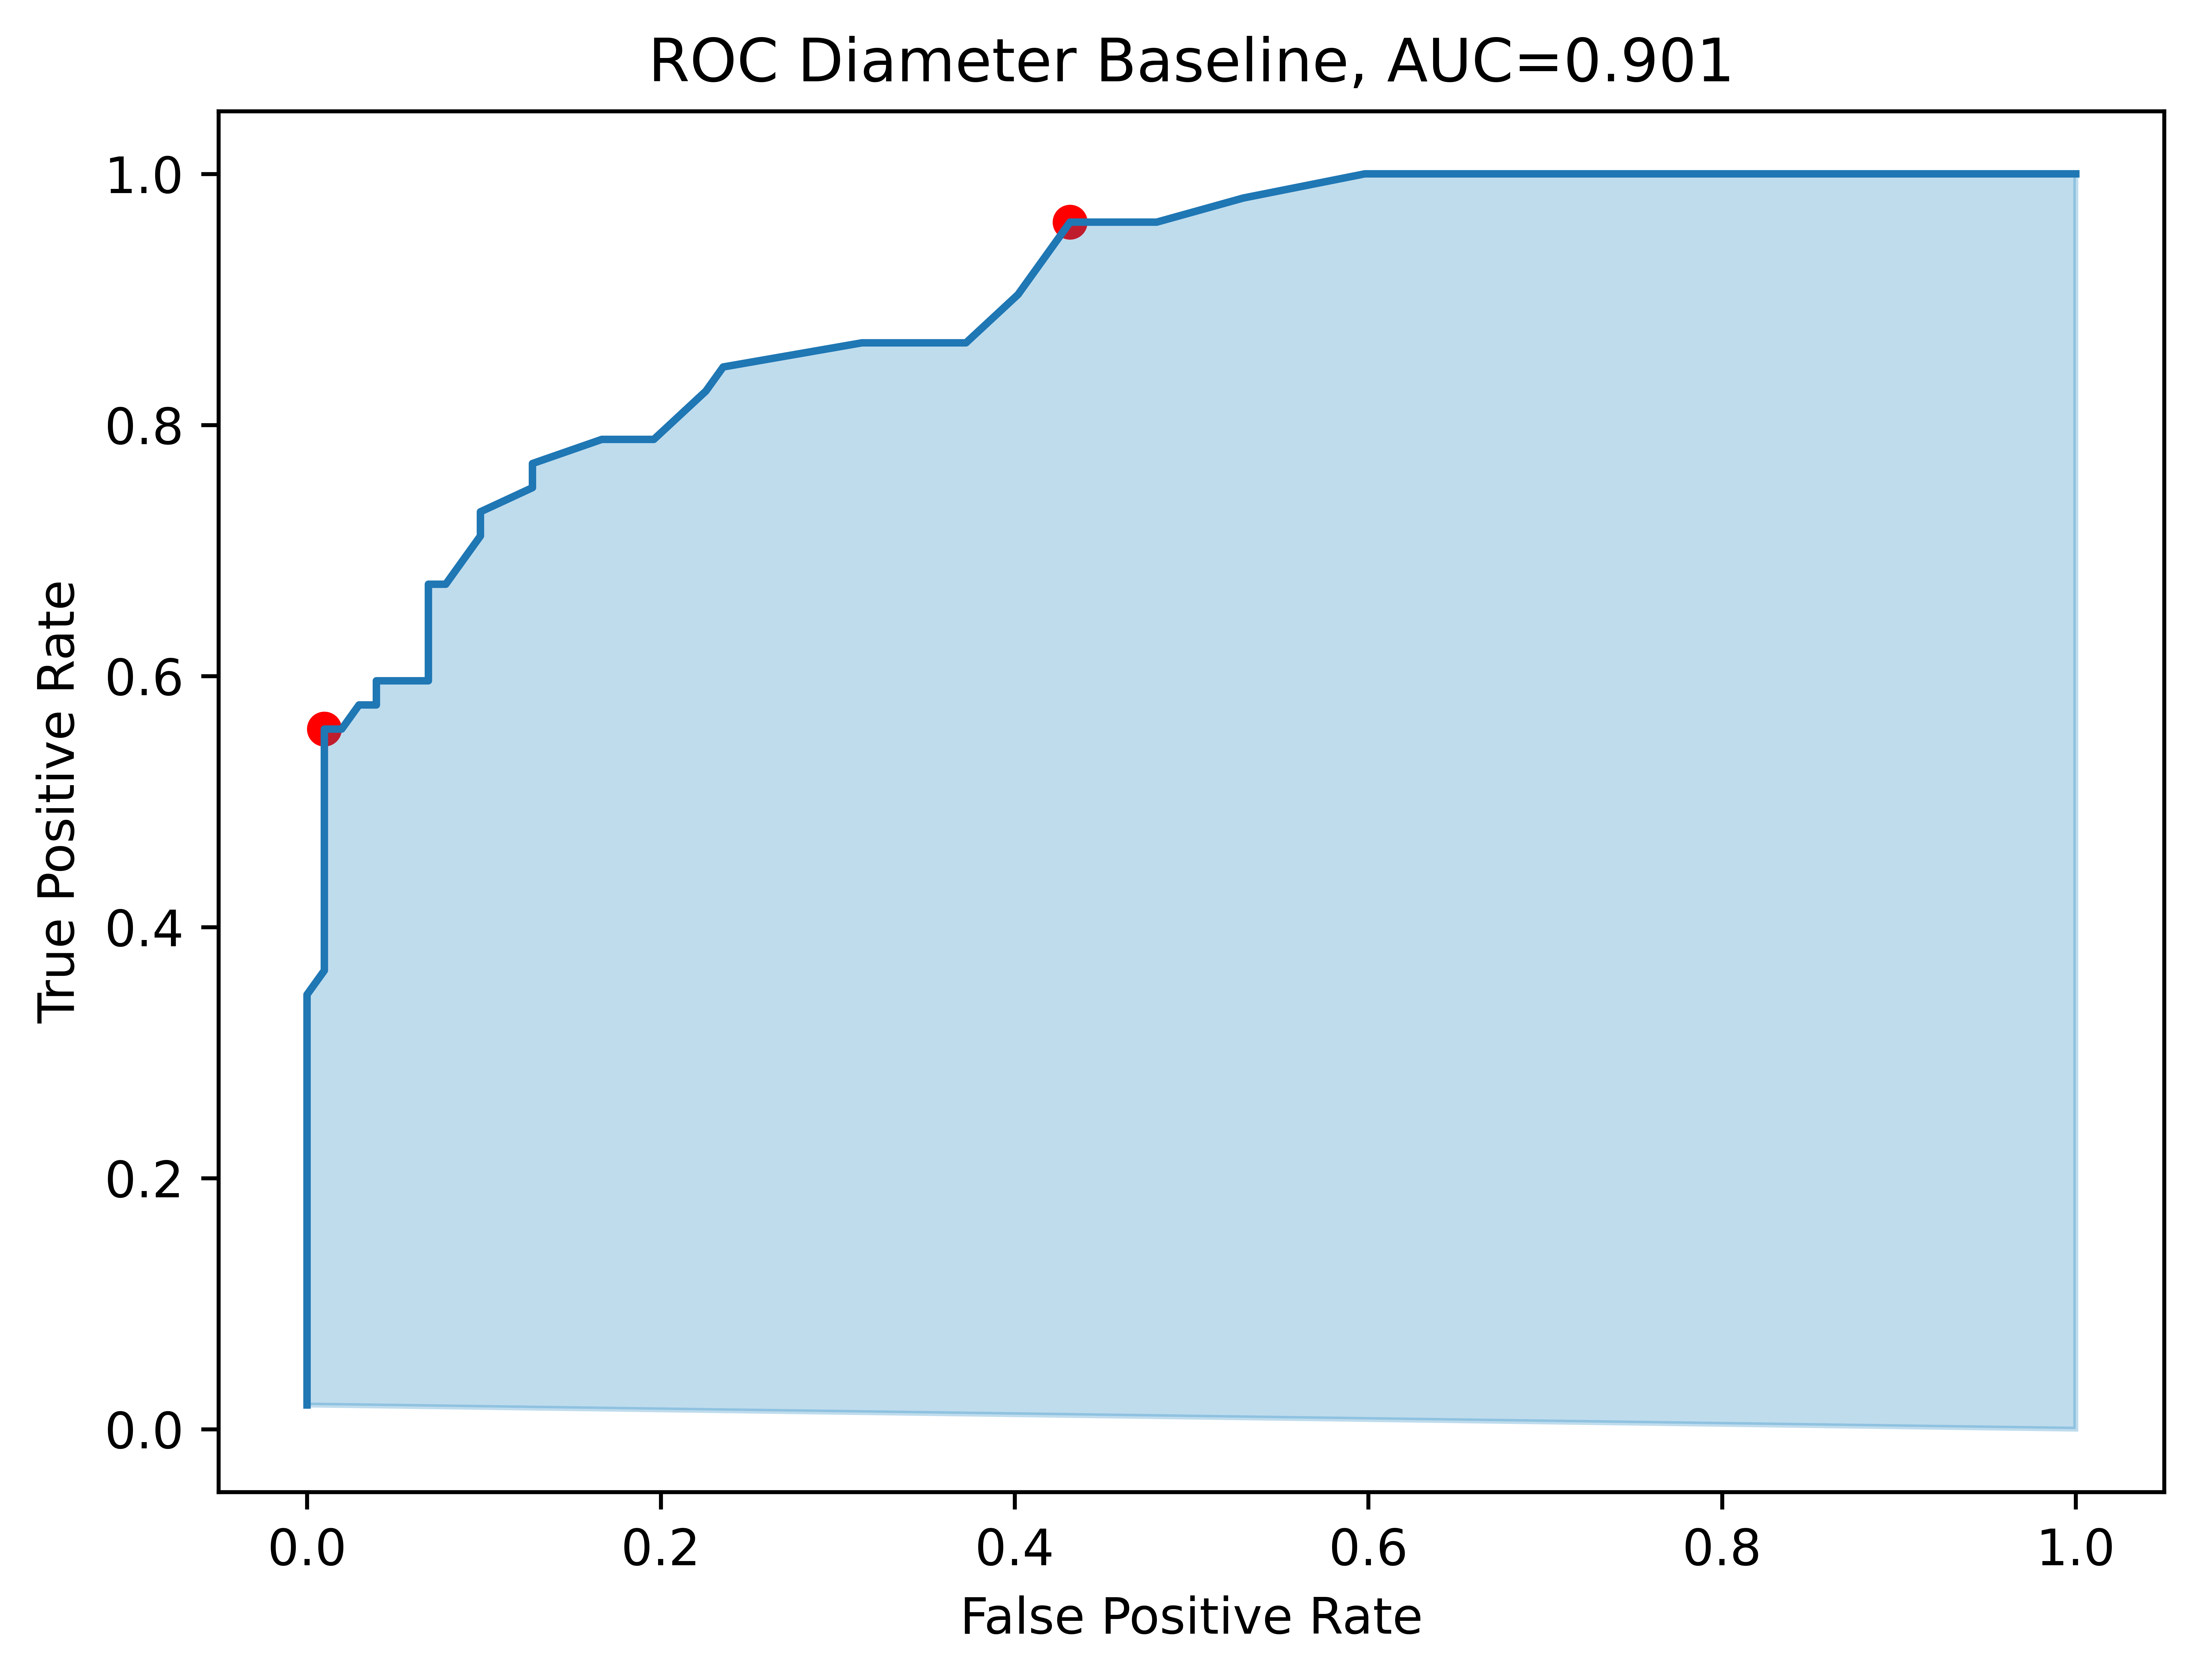

In [9]:
from matplotlib import pyplot as plt

# Create a high-resolution figure.
plt.figure(figsize=(7, 5), dpi=1200)

# Highlight key threshold points on the ROC curve.
for i in (62, 88):
    plt.scatter(fpr_diam[i], tpr_diam[i], color='red')
    print(f'diam: {threshold[i].item():.2f}, x: {fpr_diam[i].item():.2f}, y: {tpr_diam[i].item():.2f}')

"""
Fills the area under a curve defined by fp_fill (x-values) and tp_fill (y-values).

The area is shaded with a blue color (#0077bb) and 25% opacity (alpha=0.25).
"""
plt.fill(fp_fill, tp_fill, color='#0077bb', alpha=0.25)
plt.plot(fpr_diam, tpr_diam, label=f'Diameter baseline, AUC={auc_diam:.3f}')

# Add labels and title.
plt.title(f'ROC Diameter Baseline, AUC={auc_diam:.3f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')


In [25]:
model = p2ch14.model.LunaModel()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Load a saved model checkpoint from a file.
sd = torch.load(r'data-unversioned\part2\models\p2ch14\mal-finetune-depth-1_2025-05-26_12.52.21_e25_2500000_best.state')
# Load the saved model parameters into the model instance. It restores the model to a trained state so
# it can make predictions or continue training from the checkpoint.
model.load_state_dict(sd['model_state'])
# Move model or tensors to a specific device.
model.to(device)

"""
Set the model to evaluation mode, which disables training-specific layers (like dropout or batch normalization updates),
ensuring stable results during inference.
.eval() sets internal flags in the model to turn off training behaviors.
"""
model.eval()

LunaModel(
  (tail_batchnorm): BatchNorm3d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (block1): LunaBlock(
    (conv1): Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (relu1): ReLU(inplace=True)
    (conv2): Conv3d(8, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (relu2): ReLU(inplace=True)
    (maxpool): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): LunaBlock(
    (conv1): Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (relu1): ReLU(inplace=True)
    (conv2): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (relu2): ReLU(inplace=True)
    (maxpool): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block3): LunaBlock(
    (conv1): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (relu1): ReLU(inplace=True)
    (conv2): Conv3d(32, 32, kernel_siz

In [26]:
# Create a validation dataset of lung CT scan candidates labeled with malignancy and
# wraps it in a PyTorch DataLoader for batch processing during model inference.
ds = p2ch14.dsets.MalignantLunaDataset(val_stride=10, isValSet_bool=True)
dl = torch.utils.data.DataLoader(ds, batch_size=32, num_workers=4)

In [27]:
# list of predicted probabilities that a candidate is positive (i.e., a nodule).
preds = []
# list of actual labels (0 for non-nodule, 1 for nodule).
truth = []

"""
label: tensor with shape (batch_size, 2), representing one-hot labels:
    - [1, 0] for negative
    - [0, 1] for positive
"""
for inputs, labels, *_ in dl:
    inputs = inputs.to(device)
    """
    truth is a list of ground truth labels. It indicates that for each sample in the
    batch whether it is a positive class (e.g., a nodule) or not.
    label[:, 1] selects the 2nd column — i.e., the “nodule” flag because the 2end
    column is for positive labels.
    """
    truth += (labels[:, 1] > 0).tolist()
    with torch.no_grad():
        raw_logits, predicted_probabilities = model(inputs)
        # p[:, 1] contains the probability of the positive class.
        preds += predicted_probabilities[:, 1].tolist()
truth = torch.tensor(truth)
preds = torch.tensor(preds)

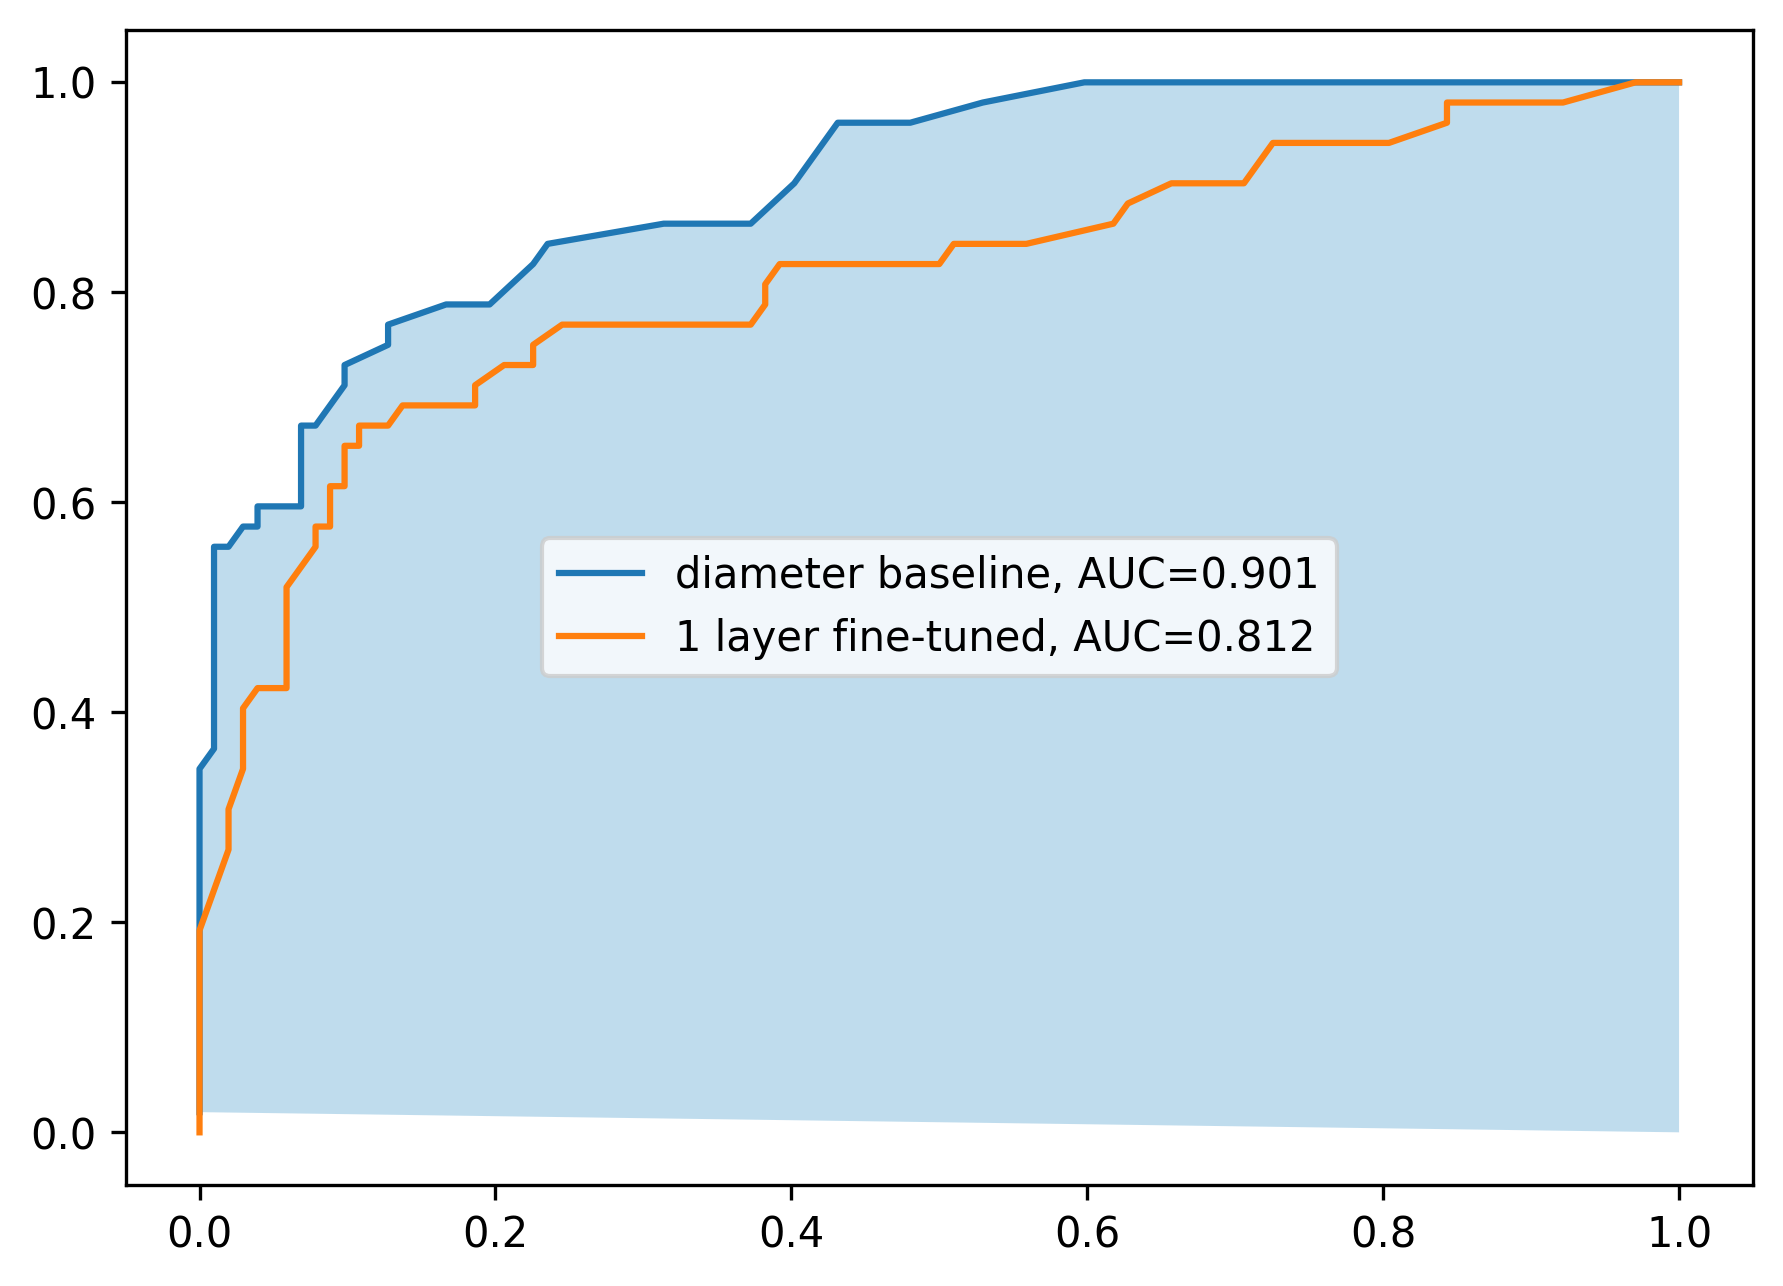

In [28]:
num_mal = truth.sum()
num_ben = len(truth) - num_mal
threshold = torch.linspace(1, 0, steps=100)
tp_finetune = ((preds[None] >= threshold[:, None]) & truth[None]).sum(1).float() / num_mal
fp_finetune = ((preds[None] >= threshold[:, None]) & ~truth[None]).sum(1).float() / num_ben
fp_finetune_diff = fp_finetune[1:]-fp_finetune[:-1]
tp_finetune_avg  = (tp_finetune[1:]+tp_finetune[:-1])/2
auc_finetune = (fp_finetune_diff * tp_finetune_avg).sum()

pyplot.figure(figsize=(7,5), dpi=300)
pyplot.fill(fp_fill, tp_fill, facecolor='#0077bb', alpha=0.25)
pyplot.plot(fpr_diam, tpr_diam, label=f'diameter baseline, AUC={auc_diam:.3f}')
pyplot.plot(fp_finetune, tp_finetune, label=f'1 layer fine-tuned, AUC={auc_finetune:.3f}')
pyplot.legend()
pyplot.savefig('roc_finetune.png')

In [30]:
model = p2ch14.model.LunaModel()
sd = torch.load(r'data-unversioned\part2\models\p2ch14\mal-finetune-depth-2_2025-05-23_18.19.25_e11_1100000_best.state', map_location='cpu')['model_state']
model.load_state_dict(sd)
model.to(device)
model.eval()


LunaModel(
  (tail_batchnorm): BatchNorm3d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (block1): LunaBlock(
    (conv1): Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (relu1): ReLU(inplace=True)
    (conv2): Conv3d(8, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (relu2): ReLU(inplace=True)
    (maxpool): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): LunaBlock(
    (conv1): Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (relu1): ReLU(inplace=True)
    (conv2): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (relu2): ReLU(inplace=True)
    (maxpool): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block3): LunaBlock(
    (conv1): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (relu1): ReLU(inplace=True)
    (conv2): Conv3d(32, 32, kernel_siz

In [31]:
# list of predicted probabilities that a candidate is positive (i.e., a nodule).
preds = []

# list of actual labels (0 for non-nodule, 1 for nodule).
truth = []

"""
inputs: input tensor (CT scan chunks).
label: tensor with shape (batch_size, 2), representing one-hot labels:
    - [1, 0] for negative
    - [0, 1] for positive
"""
for inputs, labels, *_ in dl:
    inputs = inputs.to(device)    
    truth += (labels[:, 1] > 0).tolist()
    with torch.no_grad():
        _, p = model(inputs)
        preds += p[:, 1].tolist()
truth = torch.tensor(truth)
preds = torch.tensor(preds)

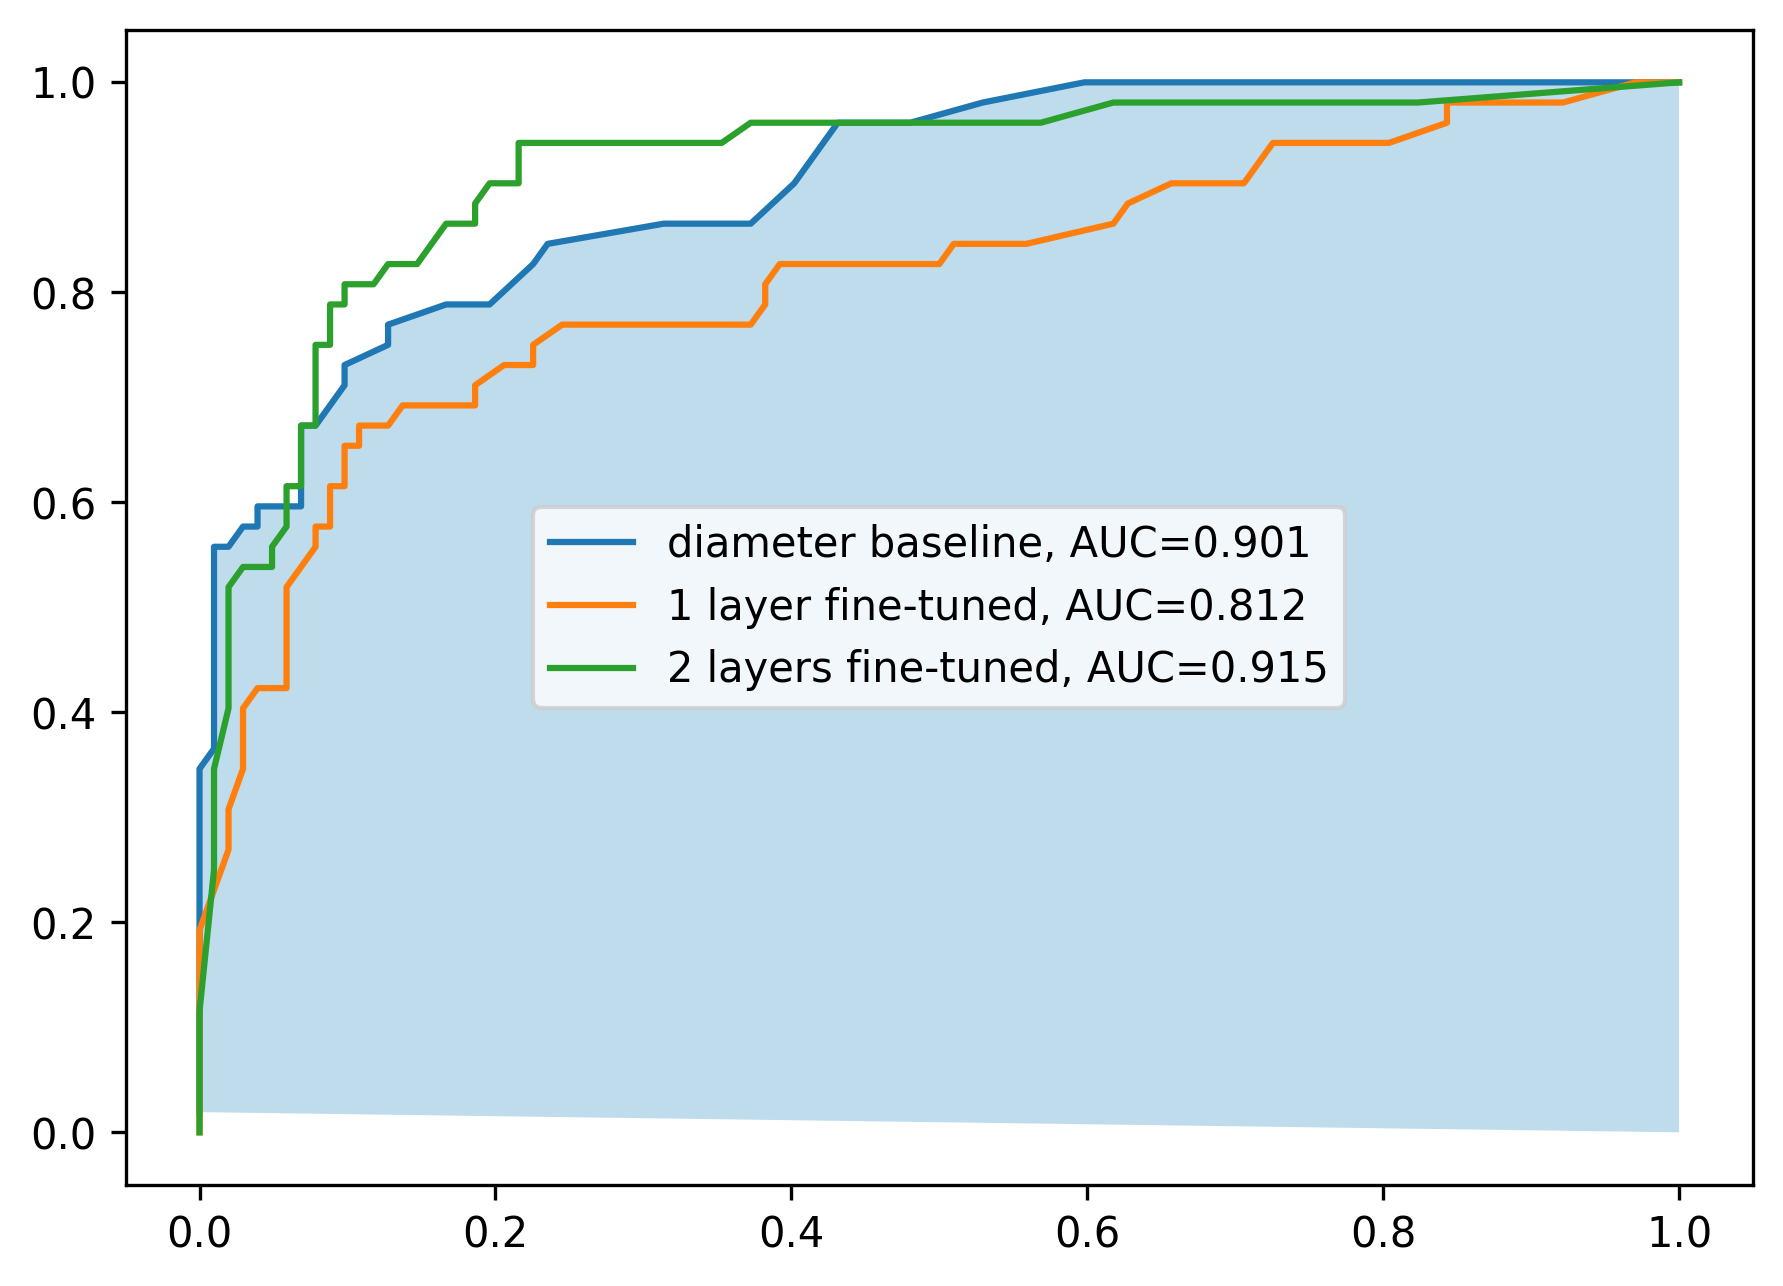

In [32]:
num_mal = truth.sum()
num_ben = len(truth) - num_mal
threshold = torch.linspace(1, 0, steps=100)
tp = ((preds[None] >= threshold[:, None]) & truth[None]).sum(1).float() / num_mal
fp = ((preds[None] >= threshold[:, None]) & ~truth[None]).sum(1).float() / num_ben

fp_diff = fp[1:] - fp[:-1]
tp_avg  = (tp[1:] + tp[:-1]) / 2
auc_modified = (fp_diff * tp_avg).sum()

pyplot.figure(figsize=(7,5), dpi=300)
pyplot.fill(fp_fill, tp_fill, facecolor='#0077bb', alpha=0.25)
pyplot.plot(fpr_diam, tpr_diam, label=f'diameter baseline, AUC={auc_diam:.3f}')
pyplot.plot(fp_finetune, tp_finetune, label=f'1 layer fine-tuned, AUC={auc_finetune:.3f}')
pyplot.plot(fp, tp, label=f'2 layers fine-tuned, AUC={auc_modified:.3f}')
pyplot.legend()
pyplot.savefig('roc_modified.png')